In [88]:
from gensim.models import Word2Vec
import utils
import re 
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = (13,13) 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [159]:
bigram_model = Word2Vec.load("trained_model/Bigram_wiki_corpus_1.model")
pos_tag_model = Word2Vec.load("trained_model/POS_TAG_wiki_corpus.model")

In [160]:
fname = "textrank_data/Neo_Nazism.txt"
with open(fname, 'r', encoding='utf_8') as f:
    data = f.read()
sentences = sent_tokenize(data)
sentences = list(re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in sentences)

In [161]:
bigram_sentences = []
pos_tag_sentences = []
for sent in sentences:
    bigram_sentences.append(utils.sent2Bigram(utils.clean_not_remain_tag(sent)))
    pos_tag_sentences.append(utils.clean_remain_tag(sent))

In [162]:
print(len(bigram_sentences), len(pos_tag_sentences))
print(bigram_sentences[:3])
print(pos_tag_sentences[:3])

11 11
[['b_neo', 'neo_nazism', 'nazism_consist', 'consist_post', 'post_world', 'world_war', 'war_militant', 'militant_social', 'social_political', 'political_movement', 'movement_seek', 'seek_revive', 'revive_implement', 'implement_ideology', 'ideology_nazism', 'nazism_e'], ['b_neo', 'neo_nazi', 'nazi_seek', 'seek_employ', 'employ_ideology', 'ideology_promote', 'promote_hatred', 'hatred_attack', 'attack_minority', 'minority_case', 'case_create', 'create_fascist', 'fascist_political', 'political_state', 'state_e'], ['b_global', 'global_phenomenon', 'phenomenon_organize', 'organize_representation', 'representation_many', 'many_country', 'country_international', 'international_network', 'network_e']]
[['neo_a', 'nazism_n', 'consist_v', 'post_n', 'world_n', 'war_n', 'militant_a', 'social_a', 'political_a', 'movement_n', 'seek_v', 'revive_v', 'implement_v', 'ideology_n', 'nazism_n'], ['neo_a', 'nazi_n', 'seek_n', 'employ_v', 'ideology_n', 'promote_v', 'hatred_a', 'attack_a', 'minority_n', '

In [164]:
# Train bigram
bigram_model.build_vocab(bigram_sentences, min_count=1, update = True)
bigram_model.train(bigram_sentences, total_examples=bigram_model.corpus_count, epochs=100)
# Train pos_tag
pos_tag_model.build_vocab(pos_tag_sentences, min_count=1, update = True)
pos_tag_model.train(pos_tag_sentences, total_examples = pos_tag_model.corpus_count, epochs=100)

(6081, 15600)

In [165]:
bigram_sent_vectors = []
pos_tag_sent_vectors = []
#Bigram
for sent in bigram_sentences:
    sent_vector = np.zeros(shape=bigram_model.vector_size)
    n = 0
    for i, word in enumerate(sent):
        if word in bigram_model.wv.vocab:
            n += 1
            sent_vector += bigram_model.wv[word]
    bigram_sent_vectors.append(sent_vector / n)
    
# POS_TAG
for sent in pos_tag_sentences:
    sent_vector = np.zeros(shape=bigram_model.vector_size)
    n = 0
    for i, word in enumerate(sent):
        if word in pos_tag_model.wv.vocab:
            n += 1
            sent_vector += pos_tag_model.wv[word]
    pos_tag_sent_vectors.append(sent_vector / n)

In [166]:
print(bigram_sent_vectors[0])

[ 3.36445864e-01  6.99841397e-01 -1.46856344e-01  1.85141463e-01
  3.05896961e-01 -9.05827529e-02 -5.69412048e-01 -2.16751557e-01
  1.96271595e-02  8.75992330e-02  1.30519700e-01  1.70205265e-01
  7.09586247e-02  6.12496730e-02  3.60688212e-01  4.75306453e-01
 -3.75839302e-02  1.13448064e-01  3.18934707e-01  3.82330065e-01
 -2.74932360e-02  5.47729534e-01  1.13102679e+00  7.41750712e-01
 -2.34882532e-01  1.39080487e-02  9.59546683e-01 -5.07335087e-01
  5.55801204e-01 -4.86489446e-01 -1.15461682e-01 -1.16210613e-01
  3.24256474e-01 -2.91878935e-01 -1.61420389e-01 -1.45337247e-01
 -3.94624771e-01  5.77685056e-01  3.89399017e-01 -5.31684787e-01
 -7.14573232e-03 -1.16241527e-01 -6.00567977e-01  4.02105024e-01
  2.25612143e-01  6.10738205e-01  1.34465743e-01 -2.01950536e-01
 -8.32453603e-01 -2.71419373e-01 -4.87395480e-01  7.75295714e-01
  5.54627206e-01 -2.20034477e-01 -1.24479740e-01 -1.12104312e-01
 -2.07362301e-02  2.95776897e-01  7.61809599e-01 -7.49256113e-02
  2.76755490e-01  1.46919

In [167]:
n = len(bigram_sentences) 
#Bigram
G_bigram = nx.Graph()
G_bigram.add_nodes_from(range(n))

#POS_TAG
G_pos_tag = nx.Graph()
G_pos_tag.add_nodes_from(range(n))

In [168]:
A_bigram = np.empty(shape=(n,n))
A_pos_tag = np.empty(shape=(n,n))
threshold = 0.7
for ix,iy in np.ndindex(A_bigram.shape):
    if ix == iy:
        A_bigram[ix, iy] = 0.0
        A_pos_tag[ix,iy] = 0.0
    else:
        #Bigram
        vA = bigram_sent_vectors[ix]
        vB = bigram_sent_vectors[iy]
        A_bigram[ix, iy] = np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))
        if A_bigram[ix, iy] > threshold:
            G_bigram.add_weighted_edges_from([(ix, iy, round(A_bigram[ix, iy], 3))])
        #POS_TAG
        vA = pos_tag_sent_vectors[ix]
        vB = pos_tag_sent_vectors[iy]
        A_pos_tag[ix, iy] = np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))
        if A_pos_tag[ix, iy] > threshold:
            G_pos_tag.add_weighted_edges_from([(ix, iy, round(A_pos_tag[ix, iy], 3))])

In [169]:
pd.DataFrame(A_bigram).head(n)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.655340,0.514806,0.761393,0.805819,0.679076,0.611067,0.961536,0.717718,0.805819,0.755012
1,0.655340,0.000000,0.627384,0.852554,0.760102,0.729117,0.674474,0.675807,0.805628,0.760102,0.733413
2,0.514806,0.627384,0.000000,0.628717,0.544512,0.691549,0.718848,0.554205,0.600294,0.544512,0.495442
3,0.761393,0.852554,0.628717,0.000000,0.887204,0.769714,0.685853,0.780885,0.947851,0.887204,0.817090
4,0.805819,0.760102,0.544512,0.887204,0.000000,0.756745,0.637151,0.776583,0.802528,1.000000,0.842120
5,0.679076,0.729117,0.691549,0.769714,0.756745,0.000000,0.758833,0.681821,0.726773,0.756745,0.758893
6,0.611067,0.674474,0.718848,0.685853,0.637151,0.758833,0.000000,0.609776,0.624487,0.637151,0.590461
7,0.961536,0.675807,0.554205,0.780885,0.776583,0.681821,0.609776,0.000000,0.803906,0.776583,0.754037
8,0.717718,0.805628,0.600294,0.947851,0.802528,0.726773,0.624487,0.803906,0.000000,0.802528,0.774854
9,0.805819,0.760102,0.544512,0.887204,1.000000,0.756745,0.637151,0.776583,0.802528,0.000000,0.842120


In [170]:
pd.DataFrame(A_pos_tag).head(n)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.827751,0.503872,0.729764,0.499076,0.669206,0.648312,0.938697,0.779859,0.499076,0.630452
1,0.827751,0.000000,0.493113,0.715311,0.555610,0.704093,0.649362,0.780314,0.745901,0.555610,0.608829
2,0.503872,0.493113,0.000000,0.292015,0.272066,0.460847,0.657266,0.515052,0.403457,0.272066,0.369197
3,0.729764,0.715311,0.292015,0.000000,0.595389,0.748911,0.615272,0.713994,0.917955,0.595389,0.564621
4,0.499076,0.555610,0.272066,0.595389,0.000000,0.532011,0.539856,0.529932,0.628232,1.000000,0.446375
5,0.669206,0.704093,0.460847,0.748911,0.532011,0.000000,0.747010,0.681183,0.753945,0.532011,0.578297
6,0.648312,0.649362,0.657266,0.615272,0.539856,0.747010,0.000000,0.660019,0.683258,0.539856,0.532271
7,0.938697,0.780314,0.515052,0.713994,0.529932,0.681183,0.660019,0.000000,0.830178,0.529932,0.673810
8,0.779859,0.745901,0.403457,0.917955,0.628232,0.753945,0.683258,0.830178,0.000000,0.628232,0.686895
9,0.499076,0.555610,0.272066,0.595389,1.000000,0.532011,0.539856,0.529932,0.628232,0.000000,0.446375


In [171]:
A = 1 - (1-A_bigram)*(1-A_pos_tag)
pd.DataFrame(A).head(n)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.940633,0.759282,0.935520,0.902730,0.893840,0.863217,0.997642,0.937858,0.902730,0.909465
1,0.940633,0.000000,0.811126,0.958024,0.893392,0.919844,0.885858,0.928779,0.950610,0.893392,0.895719
2,0.759282,0.811126,0.000000,0.737137,0.668435,0.833698,0.903640,0.783813,0.761558,0.668435,0.681723
3,0.935520,0.958024,0.737137,0.000000,0.954362,0.942178,0.879139,0.937332,0.995721,0.954362,0.920365
4,0.902730,0.893392,0.668435,0.954362,0.000000,0.886159,0.833037,0.894979,0.926586,1.000000,0.912594
5,0.893840,0.919844,0.833698,0.942178,0.886159,0.000000,0.938987,0.898559,0.932771,0.886159,0.898325
6,0.863217,0.885858,0.903640,0.879139,0.833037,0.938987,0.000000,0.867331,0.881059,0.833037,0.808447
7,0.997642,0.928779,0.783813,0.937332,0.894979,0.898559,0.867331,0.000000,0.966699,0.894979,0.919769
8,0.937858,0.950610,0.761558,0.995721,0.926586,0.932771,0.881059,0.966699,0.000000,0.926586,0.929506
9,0.902730,0.893392,0.668435,0.954362,1.000000,0.886159,0.833037,0.894979,0.926586,0.000000,0.912594


In [172]:
#Bigram
bigram_isolates_nodes = list(nx.isolates(G_bigram))
print(bigram_isolates_nodes)
#G_bigram.remove_nodes_from(bigram_isolates_nodes)

#POS_TAG
pos_tag_isolates_nodes = list(nx.isolates(G_pos_tag))
print(pos_tag_isolates_nodes)
#G_pos_tag.remove_nodes_from(pos_tag_isolates_nodes)

[]
[2, 10]


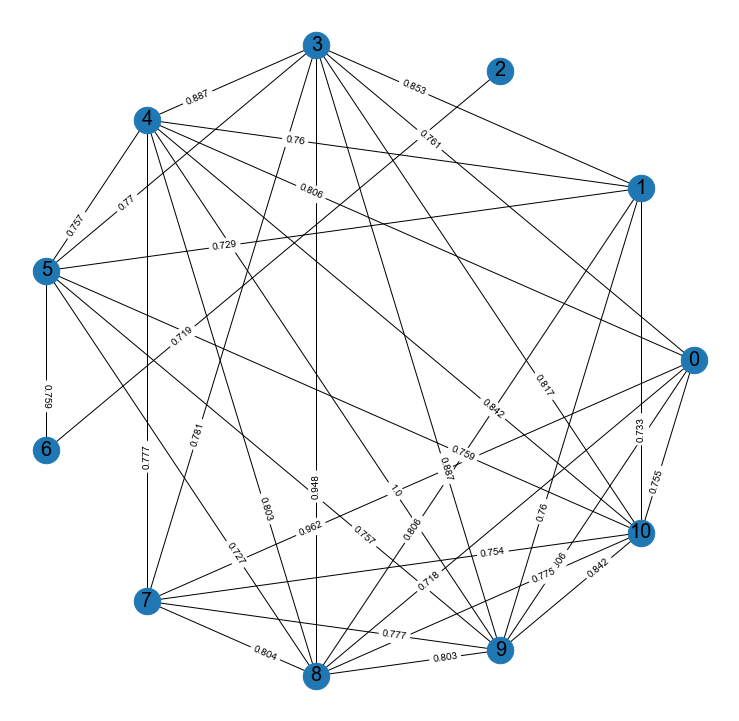

In [173]:
pos=nx.circular_layout(G_bigram) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G_bigram,pos,node_size=700)

# edges
nx.draw_networkx_edges(G_bigram,pos,edgelist=G_bigram.edges,
                    width=1)

# labels
nx.draw_networkx_labels(G_bigram,pos,font_size=20,font_family='sans-serif')
edge_labels = dict([((u, v), d['weight']) for u, v, d in G_bigram.edges(data = True)])
nx.draw_networkx_edge_labels(G_bigram, pos, edge_labels = edge_labels, label_pos=0.3)

plt.axis('off')
plt.savefig("G_bigram_neo(1).png") 
plt.show() # display

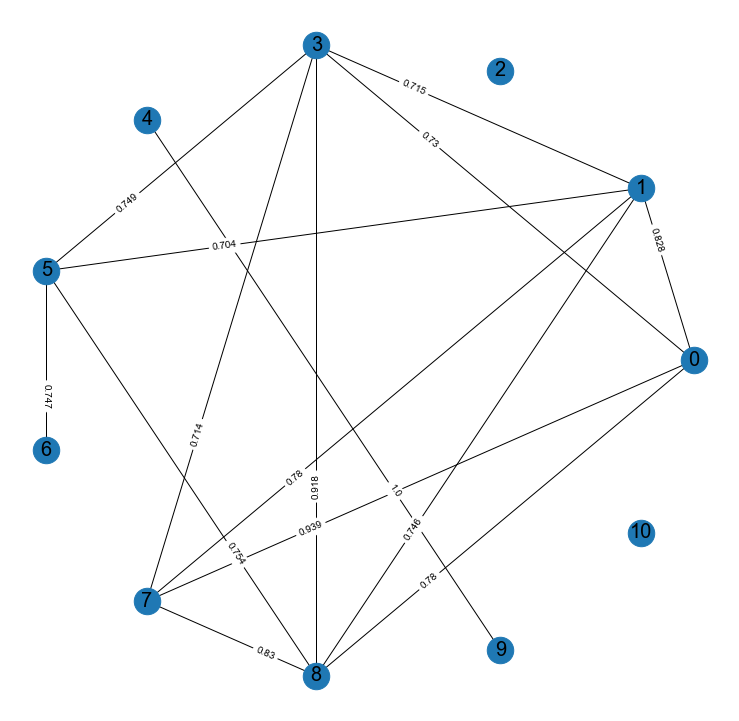

In [174]:
pos=nx.circular_layout(G_pos_tag) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G_pos_tag,pos,node_size=700)

# edges
nx.draw_networkx_edges(G_pos_tag,pos,edgelist=G_pos_tag.edges, width=1)

# labels
nx.draw_networkx_labels(G_pos_tag,pos,font_size=20,font_family='sans-serif')
edge_labels = dict([((u, v), d['weight']) for u, v, d in G_pos_tag.edges(data = True)])
nx.draw_networkx_edge_labels(G_pos_tag, pos, edge_labels = edge_labels, label_pos=0.3)

plt.axis('off')
plt.savefig("G_pos_tag_neo(1).png") 
plt.show() # display

[]


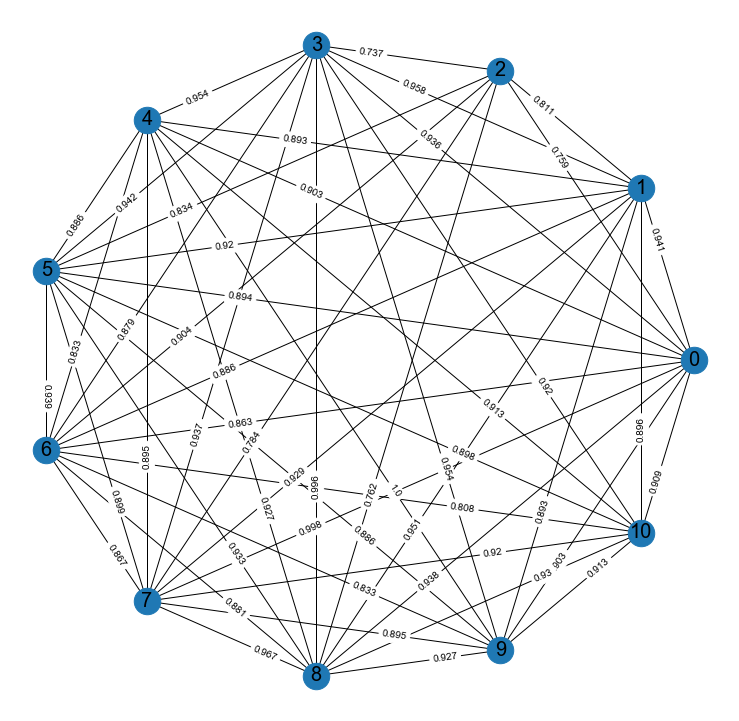

In [175]:
G = nx.Graph()
G.add_nodes_from(range(n))

for ix,iy in np.ndindex(A.shape):
    if A[ix, iy] > threshold:
        G.add_weighted_edges_from([(ix, iy, round(A[ix, iy], 3))])
isolates_nodes = list(nx.isolates(G))
print(isolates_nodes)
G.remove_nodes_from(isolates_nodes)

pos=nx.circular_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=G.edges,
                    width=1)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
edge_labels = dict([((u, v), d['weight']) for u, v, d in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos=0.3)

plt.axis('off')
plt.savefig("G_neo(1).png") 
plt.show() # display

In [19]:
def tsnescatterplot(sent_vectors):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = sent_vectors
    color_list = []
    node_labels = []
    for i in range(len(arrays)):
        node_labels.append(str(i))
        color_list.append('blue')
        
    # Reduces the dimensionality from 200 to 50 dimensions with PCA
    reduc = PCA(n_components=34).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': node_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('Graph'.format(word.title()))

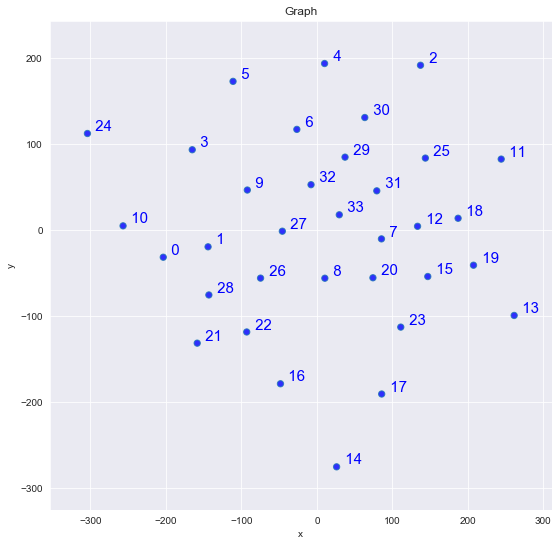

In [20]:
tsnescatterplot(pos_tag_sent_vectors)

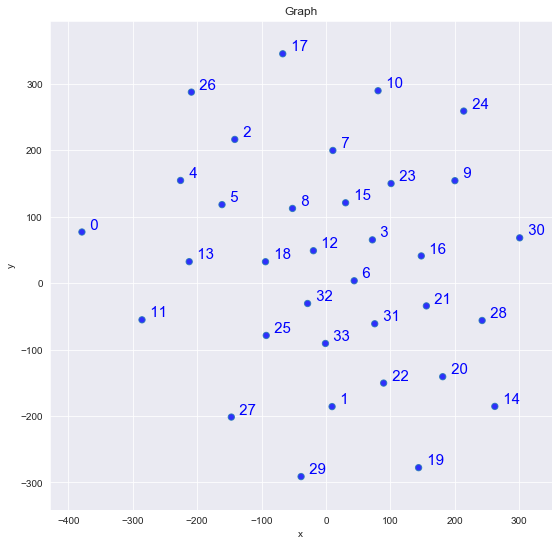

In [21]:
tsnescatterplot(bigram_sent_vectors)